# 匯入Model (Prophet)

In [ ]:
#匯入基本library

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 匯入data並處理成Prophet能接受的格式

In [2]:
data = pd.read_csv("london_merged.csv")
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
# 處理時間格式

In [3]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
mydata = data[['timestamp', 'cnt']].copy()
mydata["timestamp"] = pd.to_datetime(mydata["timestamp"])
mydata = mydata.set_index("timestamp")

# Daily resampling
daydata = mydata.resample("D").sum()

daydata['timestamp'] = daydata.index
daydata.index = range(0,len(daydata['cnt'].to_numpy()))

# No resampling for hourly prediction
hourdata = mydata
hourdata['timestamp'] = hourdata.index
hourdata.index = range(0,len(hourdata['cnt'].to_numpy()))

In [8]:
# 轉換 col名稱至 ds / y => Prophet 需要的 col 名稱

In [5]:
daydf = daydata[['timestamp','cnt']].copy()
daydf.columns = ['ds','y']

hourdf = hourdata[['timestamp','cnt']].copy()
hourdf.columns = ['ds', 'y']

In [11]:
# Prophet library

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from fbprophet import Prophet
import time

In [14]:
# Train Models

In [7]:
# Train the models
daymodel = Prophet(daily_seasonality=True)
hourmodel = Prophet(daily_seasonality=True)

# Fit the model with train set
t1 = time.time()
daymodel.fit(daydf) 
t2 = time.time()
print('d_t: ', t2-t1)
t1 = time.time()
hourmodel.fit(hourdf)
t2 = time.time()
print('d_t: ', t2-t1)

dayfuture = daymodel.make_future_dataframe(periods=365)
hourfuture = hourmodel.make_future_dataframe(periods=365, freq='H')
t1 = time.time()
daypred = daymodel.predict(dayfuture)
t2 = time.time()
print('d_t: ', t2-t1)
t1 = time.time()
hourpred = hourmodel.predict(hourfuture)
t2 = time.time()
print('d_t: ', t2-t1)

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


d_t:  0.24581170082092285
d_t:  9.630533218383789
d_t:  1.7689075469970703
d_t:  6.618719577789307


In [ ]:
# plot to see the forecast

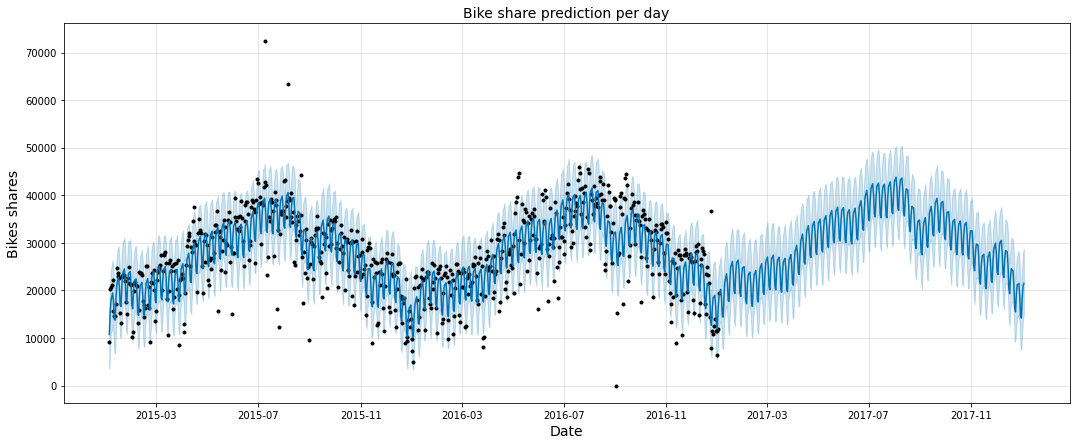

In [8]:
# Plot the day forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

daymodel.plot(daypred, ax=ax)

ax.set_title('Bike share prediction per day', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

In [17]:
# show predict data in table

In [9]:
daypred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2017-12-30,14742.752265,7922.136520,21133.217533
1092,2017-12-31,14183.459561,7530.081772,21284.068812
1093,2018-01-01,18389.123814,11095.046532,24689.636850
1094,2018-01-02,20907.321857,14035.829875,27883.254073
1095,2018-01-03,21477.363412,14814.927397,28739.255310


In [ ]:
# predict trend

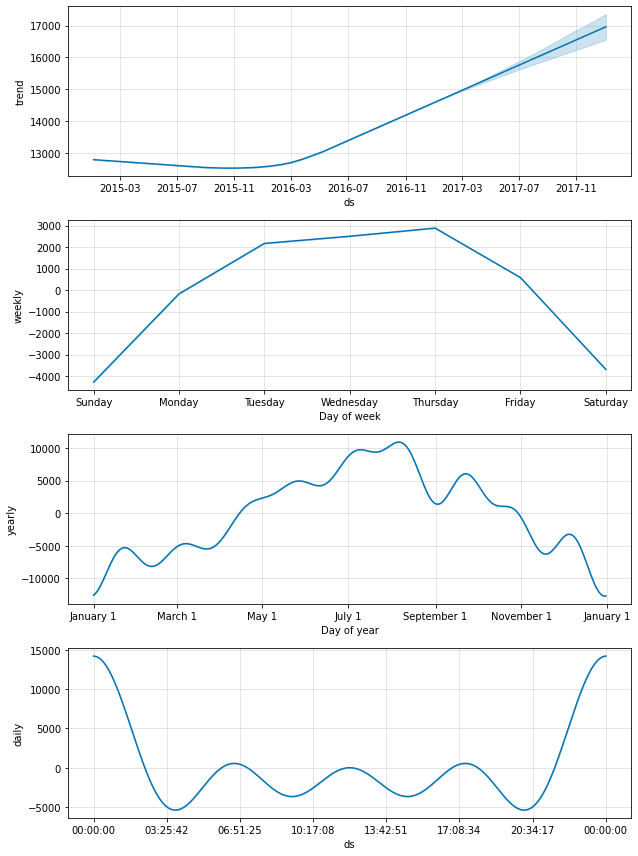

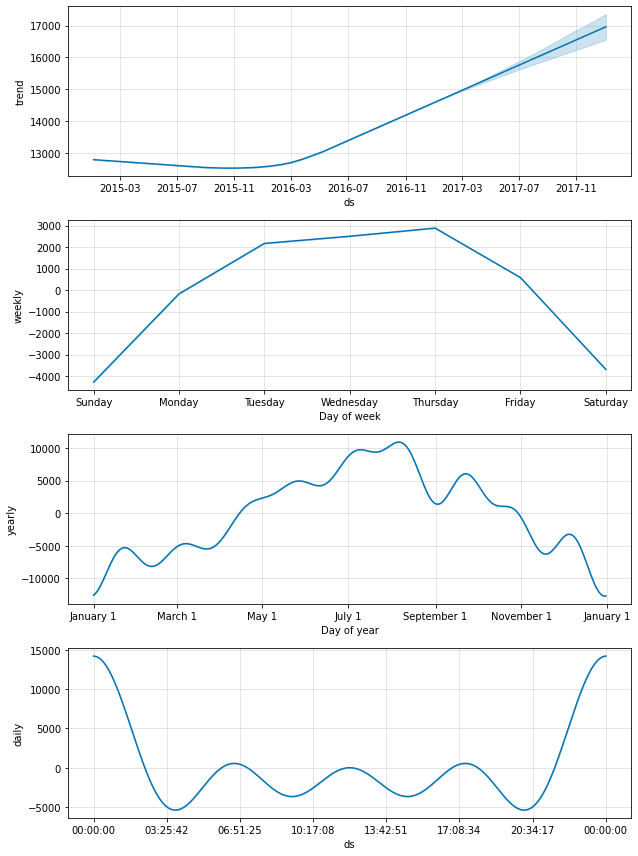

In [10]:
daymodel.plot_components(daypred)

In [21]:
# 輸出成csv

In [11]:
daypred.to_csv("daypred_df.csv")
daydata.to_csv("day_df.csv")

In [ ]:
# HOUR Predict Value Plot

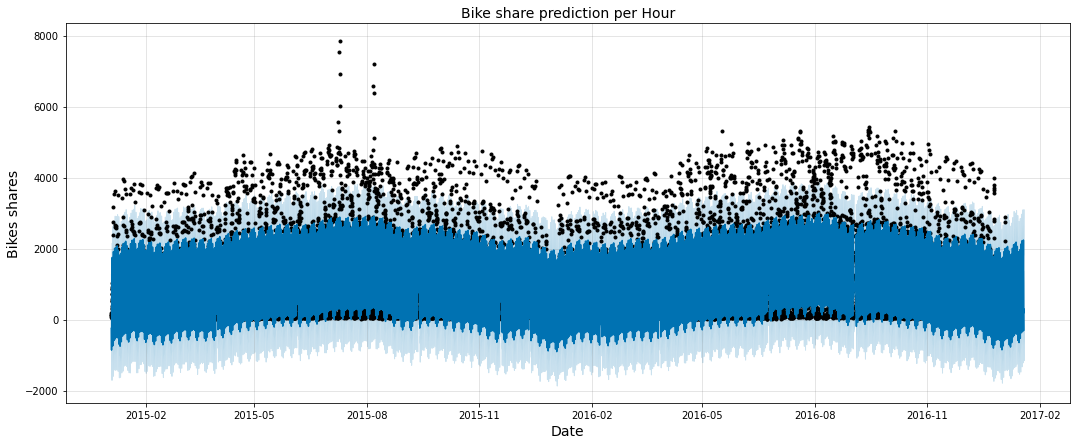

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

hourmodel.plot(hourpred, ax=ax)

ax.set_title('Bike share prediction per Hour', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

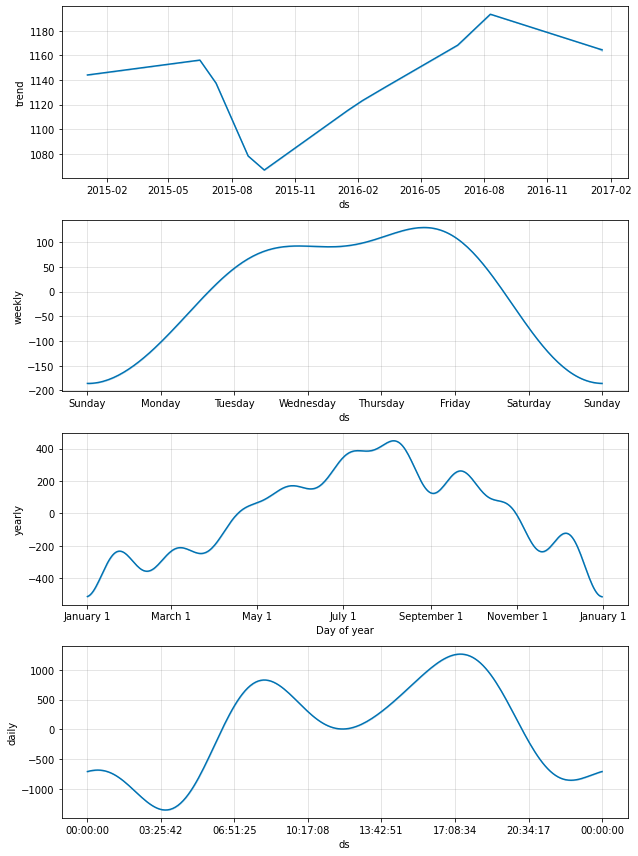

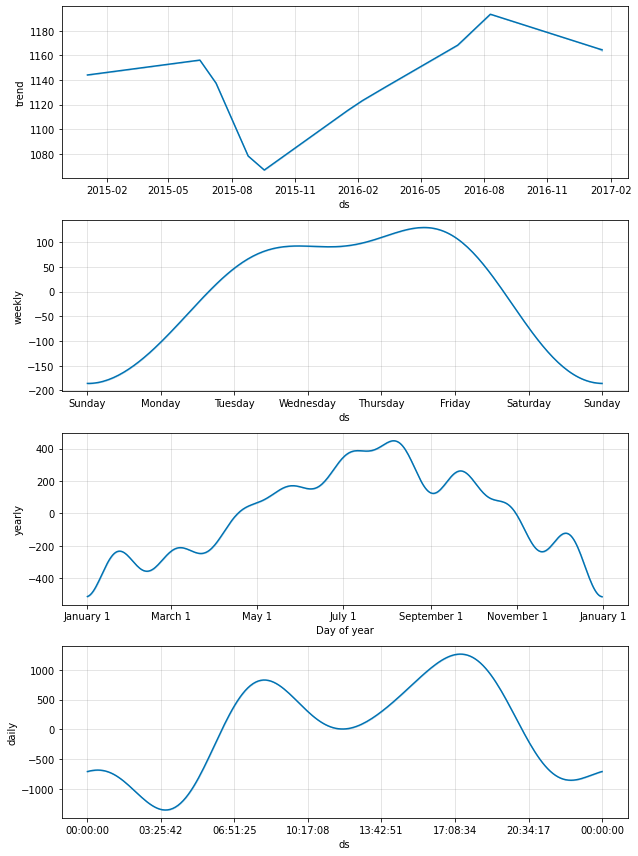

In [28]:
hourmodel.plot_components(hourpred)

In [29]:
# 輸出csv

In [12]:
hourpred.to_csv("hourpred_df.csv")
hourdata.to_csv("hour_df.csv")

# Multi-Factor Prophet

In [31]:
# What we did above is just consider relationship between time and bike-sharing
# Now we need to add more factor into the prediction 
# Remember to remove the high-correlation factor

In [ ]:
# Data Processing

In [34]:
#data["timestamp"] = pd.to_datetime(data["timestamp"])
feature_columns = [
    'weather_code',
    't1',
    'hum',
    'wind_speed',
]
target_column = ['cnt']

multidata = data[['timestamp'] + target_column + feature_columns].copy()
multidata.columns = ['ds', 'y'] + feature_columns
multidata.head()

,ds,y,weather_code,t1,hum,wind_speed
0,2015-01-04 00:00:00,182,3.0,3.0,93.0,6.0
1,2015-01-04 01:00:00,138,1.0,3.0,93.0,5.0
2,2015-01-04 02:00:00,134,1.0,2.5,96.5,0.0
3,2015-01-04 03:00:00,72,1.0,2.0,100.0,0.0
4,2015-01-04 04:00:00,47,1.0,2.0,93.0,6.5


In [ ]:
# Model Processing

In [35]:
# Train the model
multimodel = Prophet()
multimodel.add_regressor('t1')
multimodel.add_regressor('weather_code')
multimodel.add_regressor('hum')
multimodel.add_regressor('wind_speed')

# Fit the model with train set
multimodel.fit(multidata)
multifuture = multimodel.make_future_dataframe(periods=365, freq='H')
multi_hourpred = hourmodel.predict(multifuture)

In [36]:
# Plot the Prediction

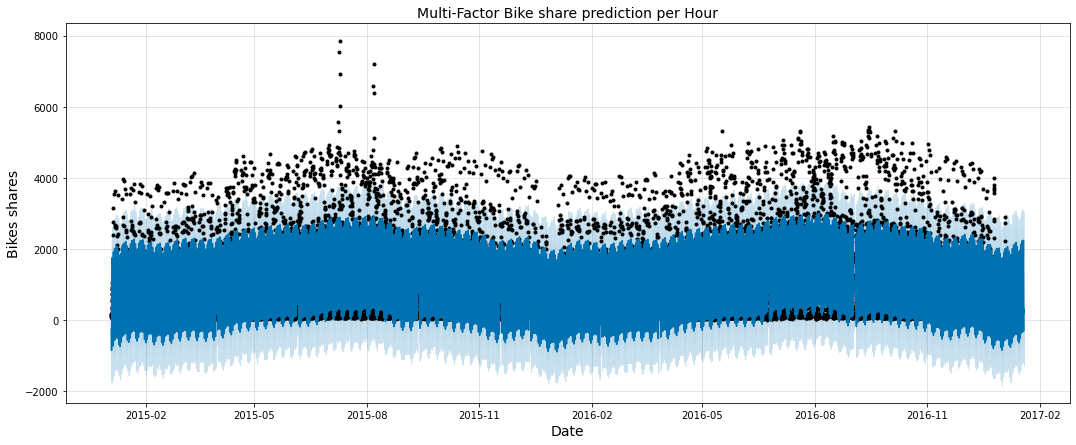

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

multimodel.plot(multi_hourpred, ax=ax)

ax.set_title('Multi-Factor Bike share prediction per Hour', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

In [ ]:
# Trend

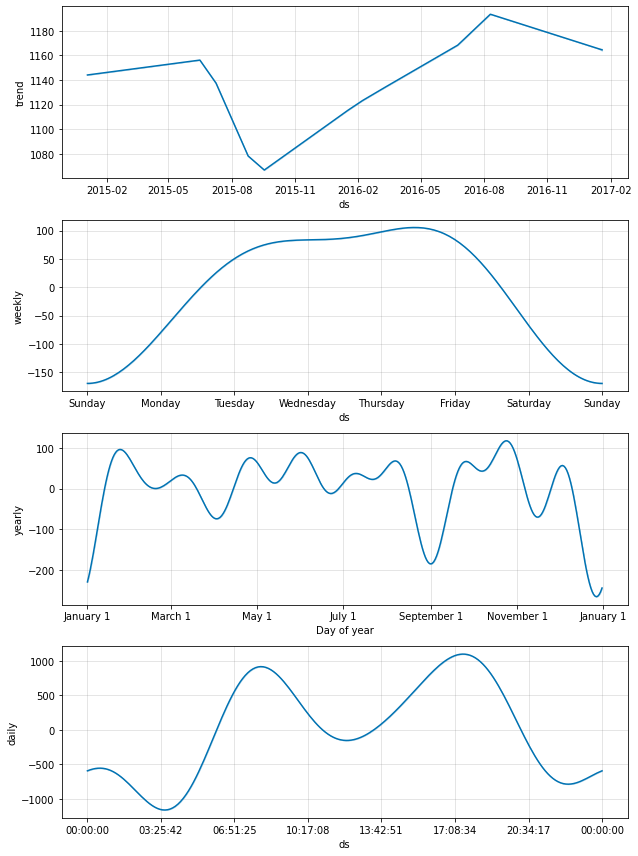

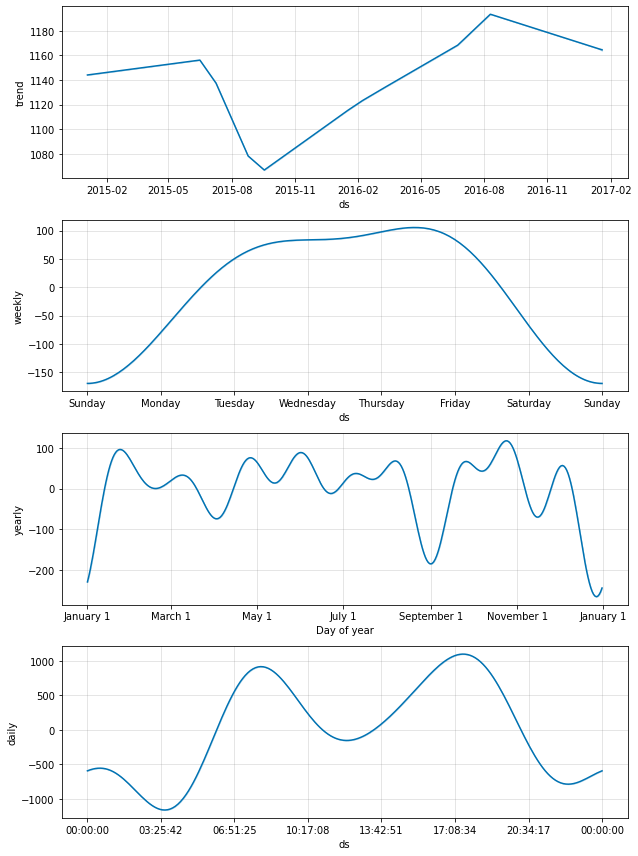

In [59]:
multimodel.plot_components(multi_hourpred)

In [39]:
#輸出csv

In [40]:
multi_hourpred.to_csv("multi_hourpred_df.csv")
multidata.to_csv("multi_df.csv")

In [ ]:
# cross validation

In [54]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(multimodel, initial='584 days', period='7 days', horizon = '1 day')

INFO:fbprophet:Making 21 forecasts with cutoffs between 2016-08-15 23:00:00 and 2017-01-02 23:00:00


  0%|          | 0/21 [00:00<?, ?it/s]

In [55]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 03:00:00,153882.318572,392.278369,326.929793,3.475321,3.221587,0.972381
1,0 days 04:00:00,113112.784085,336.322441,279.612444,5.954925,3.902065,0.992381
2,0 days 05:00:00,105401.121198,324.655388,269.821392,7.371111,4.204224,1.000000
3,0 days 06:00:00,102402.222408,320.003472,264.767795,5.231026,2.594231,1.000000
4,0 days 07:00:00,110562.686921,332.509679,281.009528,2.299357,0.712186,1.000000


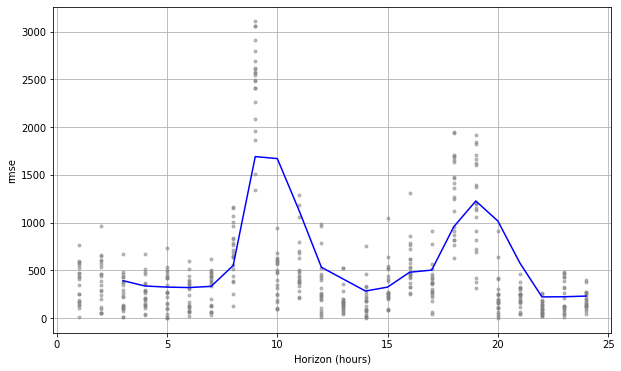

In [57]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
# Save Model

In [61]:
import json
from fbprophet.serialize import model_to_json, model_from_json

with open('multimodel.json', 'w') as fout:
    json.dump(model_to_json(multimodel), fout)  # Save model
print("Save Success")

Save Success


In [62]:
# Load Model

In [63]:
with open('multimodel.json', 'r') as fin:
    multimodel = model_from_json(json.load(fin))  # Load model
print("Load Success")

Load Success
